In [1]:
import copy
import sys
from Dropout import *
import numpy as np
import pandas as pd
from captum.attr import IntegratedGradients
import torch
from surgeon_pytorch import Inspect,Extract,get_layers
import psi
import scipy
import json
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from data_load import *
from statsmodels.stats.multitest import multipletests
from save_metric import *
from functools import partial
from model_train import compute_prediction
from VAE import *
from torch.optim import Adam, lr_scheduler, RMSprop
from tqdm import tqdm
from model_train import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

In [2]:
def compute_1d_test(reference_col: Union[pd.Series, np.ndarray],
                    current_df : Union[pd.DataFrame, np.ndarray],
                    test:str = 'ks'):
    '''
    :param reference_col: column in reference dataset
    :param current_col: DataFrame in current day/period
    :param n_bins: number of bins in denisty estimation
    :param test: ks - psi - chisq
    :return: pvalue/statistics of the test
    '''
    current_col = current_df[reference_col.name]
    start = min(min(current_col),min(reference_col))
    stop = max(max(current_col),max(reference_col))
    bins = np.linspace(start, stop, 30)

    ref_freq, _ = np.histogram(reference_col, bins = bins, density = True)
    curr_freq, _ = np.histogram(current_col, bins = bins, density = True)

    if test == 'ks':
        res = scipy.stats.ks_2samp(ref_freq, curr_freq).pvalue

    elif test == 'psi':
        # PSI < 0.1 no change - PSI >=0.1 moderate PDI > 0.2 - high
        res = psi.calculate_psi(ref_freq, ref_freq)
    elif test == 'chisq':
        res = scipy.stats.chisquare(ref_freq, curr_freq).pvalue
    else:
        print('Specify a valis test: ks - psi - chisq')

    return res

def compute_aggregated_1d(current_df: pd.DataFrame,
                          reference_df:pd.DataFrame,
                          test:str = 'ks',
                          correction:str = 'bonferroni',
                          threshold: float = 0.5):
    '''
    :param current_df: current dataframe
    :param reference_df: reference dataframe
    :param test: the type of 1d check
    :param correction: the type of correction - see availbale corrections on help(multipletests)
    :param threshold: threshold % of drifted dimensions
    :param n_bins: number of bins in denisty estimation
    :return: percentage of drifted dimension
    '''

    if test == 'ks':
        ks_pvalues = current_df.apply(lambda x: compute_1d_test(x,reference_df,test))
        res = multipletests(ks_pvalues, alpha = 0.5, method = correction)[0]

    elif test == 'psi':
        psi_values = current_df.apply(lambda x: compute_1d_test(x,reference_df,test))
        res = np.where(psi_values > 0.2, True, False)

    else:
        print('Specify a valis test: ks - psi')
        return None

    perc = round(np.count_nonzero(res) / len(res), 3)
    if perc > threshold:
            print(f'Warning! The {perc*100}% of dimensions are drifted')
    return perc, res


In [3]:
def density_func(col: pd.Series,
                 max:int):
    '''

    :param col: column of a df
    :param max: maximum value of computed density
    :return: array of density values
    '''

    bins = np.linspace(0, max, 100)
    f1,_ =  np.histogram(col, bins = bins, density=True)
    return f1

def build_model(params,in_features):

    hidden_width = params['hidden_width']
    n_additional_hidden_layers = params['n_additional_hidden_layers']
    dense_rate = params['dense_rate']
    p = params['p']


    model = MLP(in_features, hidden_width= hidden_width, n_additional_hidden_layers = n_additional_hidden_layers, dense_rate = 2, p = p)

    return model

def train_and_evaluate(params,model,dataset_train,dataset_val, num_epoch, batch_size):

    # Dataloader
    train_dataloader = DataLoader(dataset_train,batch_size)
    val_dataloader = DataLoader(dataset_val,batch_size)


    # Optimizer, loss, Lr scheduler
    optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'])
    scheduler = lr_scheduler.StepLR(optimizer, step_size = params['step_size'], gamma = params['gamma'] )



    # Training
    statistics = training_loop(num_epoch, optimizer, scheduler,
                           100, model, train_dataloader,
                           val_dataloader)

    best_epoch_mae = np.argmin(statistics['val_mae_values']) + 1
    mae_loss = statistics['val_mae_values'][best_epoch_mae -1]

    return mae_loss.detach().numpy().reshape(-1,1)

def objective(trial,dataset_train,dataset_val, in_features, num_epoch = 30, batch_size = 32):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
               'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]),
               'hidden_width': trial.suggest_int("hidden_width",9, 12),
               'n_additional_hidden_layers': trial.suggest_int("n_additional_hidden_layers", 1, 4),
               'dense_rate': trial.suggest_int("dense_rate", 1, 3),
               'p': trial.suggest_float("p",0.0,0.8),
               'step_size' : trial.suggest_int('step_size',1, 50),
               'gamma' : trial.suggest_float('gamma',0.05, 1.0)}

    model = build_model(params, in_features)
    mean_mae = train_and_evaluate(params, model, dataset_train,dataset_val,batch_size = batch_size, num_epoch = num_epoch)

    return mean_mae

In [4]:
def compute_variance(model:MLP,
                     dataset: MaeDataset,
                     B: int = 100):
    '''

    :param model: MLP model
    :param dataset: Mae Dataset su cui calcolare il Dropout
    :param B: numero di iterazione di dropout
    :return variance: varianza del dropout per ogni input
    '''
    dropout_pred = np.empty((B,len(dataset)))
    for b in tqdm(range(B)):
        dropout_pred[b,:] = np.array(compute_prediction(model, dataset, mcd = True)).reshape(-1)

    variance = dropout_pred.var(axis = 0)
    return dropout_pred,variance

In [5]:
def pca_reconstruct(dataset: np.ndarray,
                    pca_model: PCA):
    '''
    :param dataset: input dataset
    :param pca_model: pca model already fitted on X_train
    :return: per sample reconstruction error (mae), dataset reconstructed
    '''

    dataset_transformed = pca_model.transform(dataset)
    dataset_reconstructed = pca_model.inverse_transform(dataset_transformed)
    rec_error = (np.abs(dataset - dataset_reconstructed)).mean(axis=1)
    return rec_error, dataset_reconstructed

def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

def build_model_vae(params,in_features):

    hidden_dim = params['hidden_dim']
    hidden_channel = params['hidden_channels']
    latent_dim = params['latent_dim']

    enc = Vae_Encoder(in_features,hidden_dim,latent_dim,hidden_channel)
    dec = Vae_Decoder(in_features,hidden_dim,latent_dim,hidden_channel)
    model = Vae(enc,dec)

    return model

def train_and_evaluate_vae(params,model,dataset_train,dataset_val, num_epoch, batch_size):

    # Dataloader
    train_dataloader = DataLoader(dataset_train,batch_size)
    val_dataloader = DataLoader(dataset_val,batch_size)

    # Betascheduler
    betascheduler_start = params['betascheduler_start']
    betascheduler_stop = params['betascheduler_stop']
    betascheduler_ratio = params['betascheduler_ratio']
    betascheduler_train = Betascheduler(num_epoch,len(train_dataloader), start = betascheduler_start , stop = betascheduler_stop, ratio = betascheduler_ratio )
    betascheduler_val = Betascheduler(num_epoch,len(val_dataloader), start = betascheduler_start , stop = betascheduler_stop , ratio = betascheduler_ratio)

    # Optimizer, loss, Lr scheduler
    optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'])
    criterion = getattr(torch.nn, params['criterion'])(reduction = params['reduction'])

    scheduler = lr_scheduler.StepLR(optimizer, step_size = num_epoch, gamma = 1 )



    # Training
    statistics = vae_training_loop(num_epoch, optimizer, scheduler,
                                   model,
                                   train_dataloader, val_dataloader, betascheduler_train, betascheduler_val,
                                   strategy1 = params['strategy'], patience = 50, criterion = criterion)


    best_mae_epoch = np.argmin(statistics['loss_mae_val']) + 1
    best_mae = statistics['loss_mae_val'][best_mae_epoch - 1]

    return best_mae.detach().numpy().reshape(-1,1)

def objective_vae(trial,dataset_train,dataset_val, in_features, num_epoch = 200, batch_size = 32):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
               'criterion': trial.suggest_categorical("criterion", ['MSELoss','BCELoss']),
               'reduction': trial.suggest_categorical("reduction", ['sum','mean']),
               'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]),
               'strategy': trial.suggest_categorical("strategy", [True,False]),
               'hidden_dim': trial.suggest_int("hidden_dim",32, 42),
               'hidden_channels': trial.suggest_int("hidden_channels", 1, 4),
               'latent_dim': trial.suggest_int("latent_dim",3, 7),
               'betascheduler_start': trial.suggest_float("betascheduler_start",0.05,0.2),
               'betascheduler_stop': trial.suggest_float("betascheduler_stop",0.15,0.4),
               'betascheduler_ratio': trial.suggest_float("betascheduler_ratio",0.5,1.0)}

    model = build_model_vae(params, in_features)
    mean_mae = train_and_evaluate_vae(params, model, dataset_train,dataset_val,batch_size = batch_size, num_epoch = num_epoch)

    return mean_mae




In [6]:
#Data Load
#api = KaggleApi()
#api.authenticate()
#api.competition_download_files('bike-sharing-demand')

#Data extraction
#zf = ZipFile(os.path.join(ROOT, 'bike-dataset', 'bike-sharing-demand.zip'))
#zf.extractall(os.path.join(ROOT, 'bike-dataset'))  #save files in selected folder
#zf.close()

# Data Loading
train_dataset = pd.read_csv(os.path.join(ROOT, 'bike-dataset', 'train.csv'))
test_dataset = pd.read_csv(os.path.join(ROOT, 'bike-dataset', 'test.csv'))

CHECKPOINT_ROOT2 = os.path.join(ROOT,'model_bike')

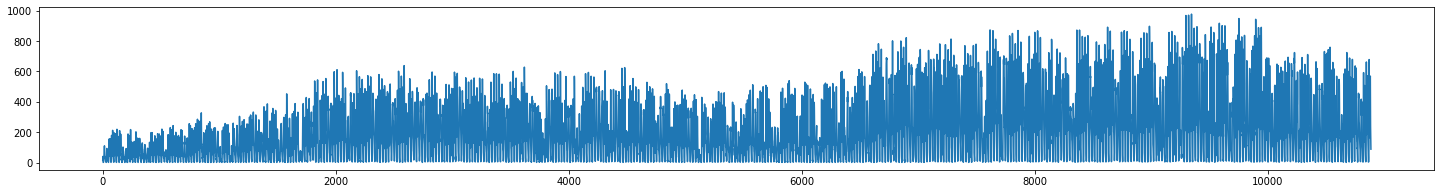

In [7]:
# Preprocessing: Generating Dummies, Feature Engineering
df_list = []

for df in [train_dataset, test_dataset]:
    season = pd.get_dummies(df['season'], prefix='season')
    weather = pd.get_dummies(df['weather'], prefix='weather')
    temp = pd.concat([df, weather, season], axis=1).drop(columns= ['weather','season']                                                    )
    temp['hour'] = [t.hour for t in pd.DatetimeIndex(temp.datetime)]
    temp['day'] = [t.dayofweek for t in pd.DatetimeIndex(temp.datetime)]
    temp['month'] = [t.month for t in pd.DatetimeIndex(temp.datetime)]
    temp['year'] = [t.year for t in pd.DatetimeIndex(temp.datetime)]
    temp['year'] = temp['year'].map({2011: 0, 2012: 1})
    temp.drop(['datetime'], axis=1, inplace=True)
    df_list.append(copy.deepcopy(temp))

train_df = df_list[0].copy().drop(columns=['registered', 'casual'])
test_df = df_list[1].copy()

plt.figure(figsize=(25, 3))
plt.plot(np.arange(len(train_dataset['count'])), train_dataset['count'])
plt.show()

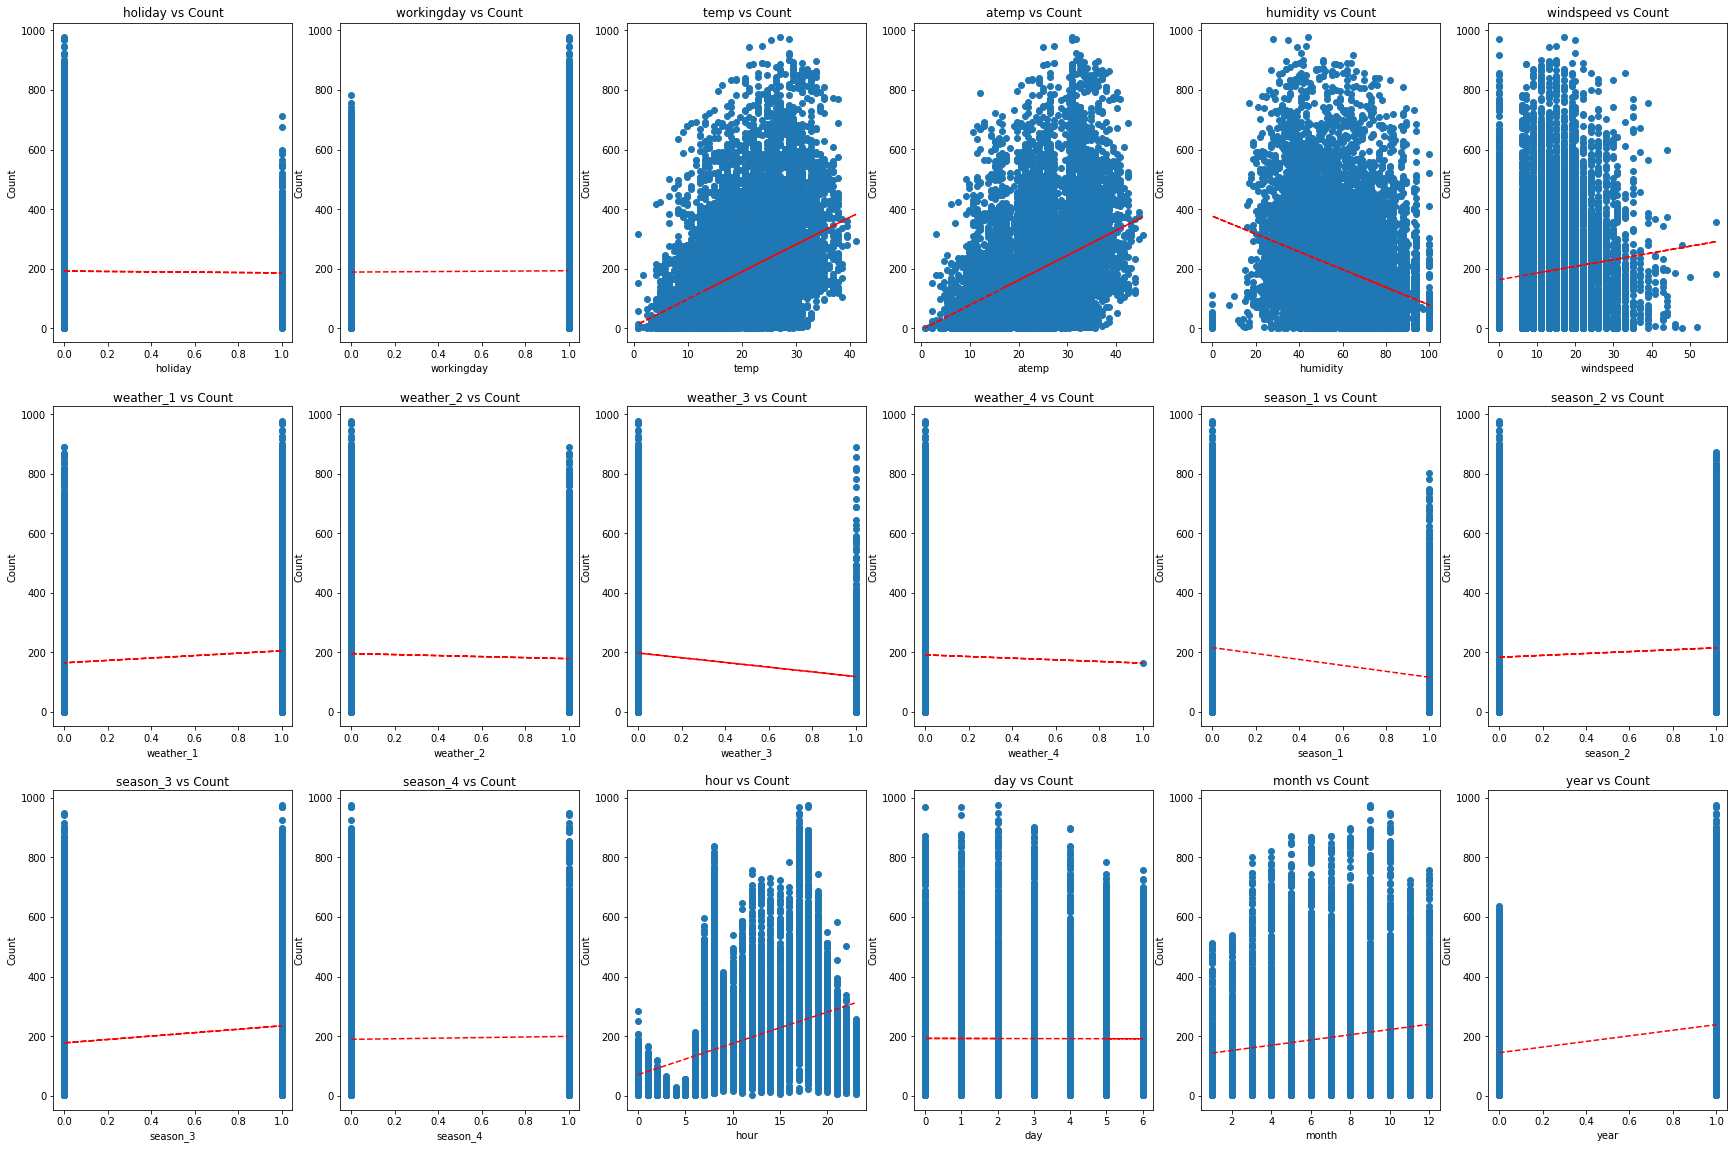

In [8]:
fig, axs = plt.subplots(nrows = 3, ncols=6, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, list(train_df.drop('count', axis = 1).columns))):
    x = train_df[col].values
    pf = np.polyfit(x, train_df['count'].values, 1)
    p = np.poly1d(pf)

    ax.plot(x, train_df['count'].values, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Count')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

 Humidity median: 62.0 


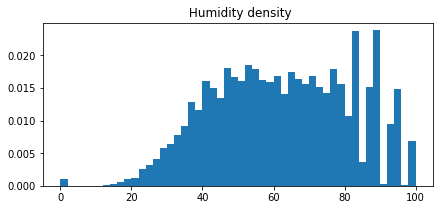

In [8]:
print(f''' Humidity median: {train_df['humidity'].median()} ''')

plt.figure(figsize = (7,3) )
plt.title(' Humidity density')
plt.hist(train_df['humidity'], density = True, bins = 50)
plt.show()

In [8]:
# Scaling

labels = np.where(train_df['hour'].isin(np.arange(7,20)), True, False)
train_by_season = train_df[labels == True]  # train: 7/19
test = train_df[labels == True] # test: 20/6
train, val = train_test_split(train_by_season)

col_list = list(train.columns)
col_mapper = dict(zip(col_list, list(np.arange(len(col_list)))))

min_max_scaler = MinMaxScaler()
train = min_max_scaler.fit_transform(train)
val = min_max_scaler.transform(val)
test = min_max_scaler.transform(test)

x_train = np.delete(train, col_mapper['count'], axis = 1)
y_train = train[:, col_mapper['count'] ]

x_val = np.delete(val, col_mapper['count'], axis = 1)
y_val = val[:, col_mapper['count']]

x_test = np.delete(test, col_mapper['count'], axis = 1)
y_test = test[:, col_mapper['count']]

In [9]:
# VAE

batch_size = 32
dataset_train_vae = VaeDataset(x_train)
train_dataloader_vae = DataLoader(dataset_train_vae,batch_size)

dataset_val_vae = VaeDataset(x_val)
val_dataloader_vae = DataLoader(dataset_val_vae,batch_size)

dataset_test_vae = VaeDataset(x_test)
test_dataloader_vae = DataLoader(dataset_test_vae, batch_size)

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
obj = partial(objective_vae, dataset_train = dataset_train_vae, dataset_val = dataset_val_vae,num_epoch = 50, in_features = 18)
study.optimize(obj, n_trials = 30)

In [15]:
LOAD = False
if LOAD == True:
    best_param = json_load(os.path.join(ROOT,'model_bike','VAE','best_params.json'))
else:
    best_trial = study.best_trial
    best_param = best_trial.params

for key, value in best_param.items():
    print("{}: {}".format(key, value))

learning_rate: 0.0007161981345319652
criterion: BCELoss
reduction: sum
optimizer: Adam
strategy: False
hidden_dim: 41
hidden_channels: 1
latent_dim: 4
betascheduler_start: 0.09582216703202832
betascheduler_stop: 0.28080912093741767
betascheduler_ratio: 0.7949348025832893


In [16]:
with open(os.path.join(ROOT,'model_bike','VAE','best_params.json'), 'w') as f:
    json.dump(best_param, f)

In [124]:
# model's parameters
vae_lr = best_param['learning_rate']  #0.0002
vae_num_epochs = 5000
strategy1 = best_param['strategy']
start = best_param['betascheduler_start']
stop = best_param['betascheduler_stop']
ratio = best_param['betascheduler_ratio']


# model initialization

betascheduler_train = Betascheduler(vae_num_epochs,len(train_dataloader_vae)+1, start = start, stop = stop, ratio = ratio )
betascheduler_val = Betascheduler(vae_num_epochs,len(val_dataloader_vae)+1, start = start, stop = stop, ratio = ratio)

# Optimization
criterion = getattr(torch.nn, best_param['criterion'])(reduction = best_param['reduction'])
# nn.MSELoss(reduction = 'sum')

# model initialization
bike_vae = build_model_vae(best_param,18)
vae_optimizer = getattr(torch.optim, best_param['optimizer'])(bike_vae.parameters(), lr = vae_lr)

# Learning Rate schedule
vae_scheduler = lr_scheduler.StepLR(vae_optimizer, step_size = vae_num_epochs, gamma = 1 )

--------------------------------------------------------
Betascheduler:
current beta = 0.09582216703202832
current iteration = 0
current epoch = 0
--------------------------------------------------------


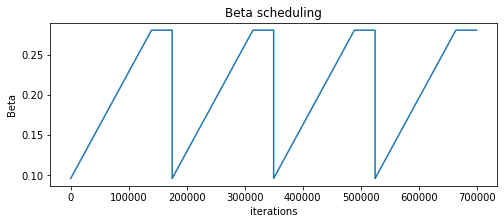

In [18]:
betascheduler_val.summary()

plt.figure(figsize = (8,3))
plt.plot(np.arange(betascheduler_train.n_iter), betascheduler_train.schedule[:-1])
plt.title('Beta scheduling')
plt.xlabel('iterations')
plt.ylabel('Beta')
plt.show()

In [193]:
# load model

if LOAD:
    checkpoint = torch.load(os.path.join(ROOT,'model_bike','VAE','vae_model.pt'))
    bike_vae.load_state_dict(checkpoint['model_state_dict'])
    vae_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    vae_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    vae_epoch = checkpoint['epoch']
    vae_loss = checkpoint['loss']

In [19]:
vae_statistics = vae_training_loop(vae_num_epochs, vae_optimizer, vae_scheduler, bike_vae, train_dataloader_vae,
                                    val_dataloader_vae, betascheduler_train, betascheduler_val, strategy1 = False, criterion = criterion )


Epoch: 1  Lr: 0.00071620  Loss: Train = [1338.1151] - Val = [1396.9366]  KLD: Train = [4.3861] - Val = [7.9642]  REC: Train = [345.6791] - Val = [321.4681]  Time one epoch (s): 0.4894 
Epoch: 2  Lr: 0.00071620  Loss: Train = [1533.2151] - Val = [1606.0598]  KLD: Train = [31.3371] - Val = [51.8652]  REC: Train = [301.7792] - Val = [277.3149]  Time one epoch (s): 0.4864 
Epoch: 3  Lr: 0.00071620  Loss: Train = [1725.5012] - Val = [1877.8903]  KLD: Train = [73.5856] - Val = [101.6974]  REC: Train = [267.8282] - Val = [243.5747]  Time one epoch (s): 0.3614 
Epoch: 4  Lr: 0.00071620  Loss: Train = [2321.1398] - Val = [3061.3103]  KLD: Train = [163.6953] - Val = [223.1544]  REC: Train = [217.6396] - Val = [184.2041]  Time one epoch (s): 2.0792 
Epoch: 5  Lr: 0.00071620  Loss: Train = [3688.2921] - Val = [4727.1514]  KLD: Train = [256.5492] - Val = [295.7887]  REC: Train = [176.0254] - Val = [160.6409]  Time one epoch (s): 0.6077 
Epoch: 6  Lr: 0.00071620  Loss: Train = [5223.1837] - Val = [5

In [20]:
best_epoch_loss_vae = np.argmin(vae_statistics['loss_mae_val']) + 1
best_loss_vae = vae_statistics['loss_mae_val'][best_epoch_loss_vae - 1]

print(f'Best val mae: {best_loss_vae: .5f} epoch: {best_epoch_loss_vae}')

Best val mae:  0.01292 epoch: 4946


In [21]:
# Save the model

EPOCH = best_epoch_loss_vae
CHECKPOINT_ROOT2 = os.path.join(ROOT,'model_bike')
LOSS = best_loss_vae

if not os.path.exists(CHECKPOINT_ROOT2):
    os.makedirs(CHECKPOINT_ROOT2)

torch.save({
            'epoch': EPOCH,
            'model_state_dict':bike_vae.state_dict(),
            'optimizer_state_dict': vae_optimizer.state_dict(),
            'scheduler_state_dict': vae_scheduler.state_dict(),
            'loss': LOSS,
            }, os.path.join(CHECKPOINT_ROOT2,'VAE','vae_model.pt'))

In [22]:
vae_statistics['loss_mae_val'] = list(np.array(vae_statistics['loss_mae_val']).reshape(-1))
vae_statistics['loss_mae_train'] = list(np.array(vae_statistics['loss_mae_train']).reshape(-1))
for k in vae_statistics.keys():
    try:
        vae_statistics[k] = [float(el) for el in vae_statistics[k]]
    except:
        pass
with open(os.path.join(CHECKPOINT_ROOT2, 'VAE', 'model_stats.json'), 'w+') as f:
    json.dump(vae_statistics, f)

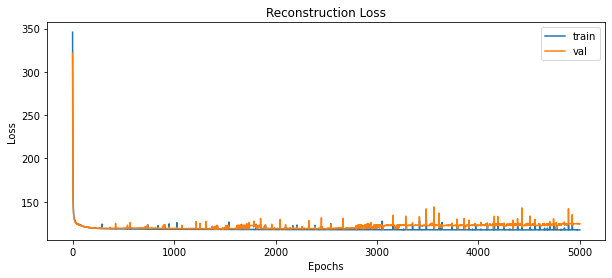

In [23]:
fig = plt.figure(figsize =(10,4))
plt.title(f'Reconstruction Loss' )
plt.plot(np.arange(vae_num_epochs),vae_statistics['loss_rec_train'], label = 'train')
plt.plot(np.arange(vae_num_epochs), vae_statistics['loss_rec_val'] ,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2,'VAE','rec_loss.png'))

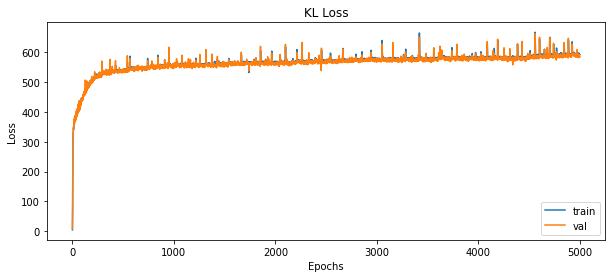

In [24]:
fig = plt.figure(figsize =(10,4))

plt.title(f'KL Loss')
plt.plot(np.arange(vae_num_epochs), np.array(vae_statistics['loss_kld_train']), label = 'train')
plt.plot(np.arange(vae_num_epochs), np.array(vae_statistics['loss_kld_val']) ,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2,'VAE','kl_loss.png'))

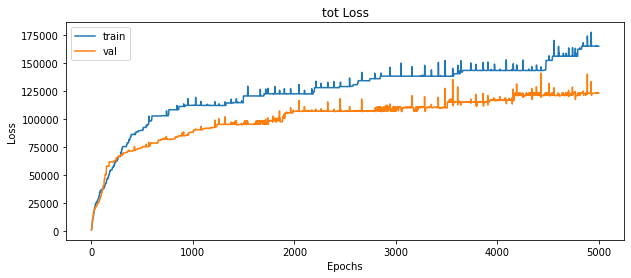

In [25]:
fig = plt.figure(figsize =(10,4))

plt.title(f'tot Loss')
plt.plot(np.arange(vae_num_epochs),np.array(vae_statistics['loss_values_train']), label = 'train')
plt.plot(np.arange(vae_num_epochs),np.array(vae_statistics['loss_values_val']) ,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2,'VAE','tot_loss.png'))

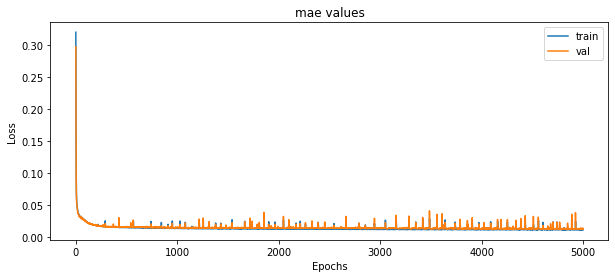

In [26]:
fig = plt.figure(figsize =(10,4))

plt.title(f'mae values')

plt.plot(np.arange(vae_num_epochs),np.array(vae_statistics['loss_mae_train']), label = 'train')
plt.plot(np.arange(vae_num_epochs),np.array(vae_statistics['loss_mae_val']) ,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2,'VAE','mae_values.png'))

### VAE ***with mean***

In [98]:
res = np.empty((100, len(dataset_train_vae), 18))
bike_vae.eval()
bike_vae.training = True

with torch.no_grad():
    for idx_batch, el in tqdm(enumerate(DataLoader(dataset_train_vae,1, shuffle = False))):
        for b in range(100):
            pred, _ = bike_vae(el)
            res[b,idx_batch,:] = pred
train_mean_vae = res.mean(axis= 0)

4442it [04:30, 16.40it/s]


In [101]:
train_mean_vae.shape


(4442, 18)

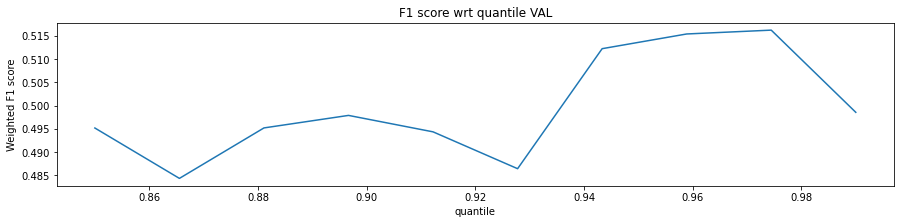

 best quantile 0.9744444444444444, F1 macro: 0.5162170122164478

 classification report 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      3997
           1       0.17      0.07      0.10       445

    accuracy                           0.87      4442
   macro avg       0.54      0.52      0.52      4442
weighted avg       0.83      0.87      0.85      4442



In [103]:
f1_w = []
quantile_list = np.linspace(0.85,0.99,10)
for q in quantile_list:
    train_prob = np.where(train_mean_vae > np.quantile(train_mean_vae,q = q, axis = 0), 1, 0).mean(axis = 1)
    train_pred_anomalies_vae_mean = np.where(train_prob > (1-q) + 0.04 ,1,0 )
    f1_w.append(f1_score(train_anomalies_mae, train_pred_anomalies_vae_mean,average = 'macro'))

fig = plt.figure(figsize = (15,3))
plt.xlabel('quantile')
plt.ylabel('Weighted F1 score')
plt.title('F1 score wrt quantile VAL')
plt.plot(quantile_list, f1_w)
plt.show()
fig.savefig(os.path.join(ROOT,'model_bike','PCA', 'quantile_gird_search2.png'))

quantile_vae_mean_temp = quantile_list[np.argmax(f1_w)]
print(f' best quantile {quantile_list[np.argmax(f1_w)]}, F1 macro: {np.max(f1_w)}')

train_prob = np.where(train_mean_vae > np.quantile(train_mean_vae,q = quantile_vae_mean_temp, axis = 0), 1, 0).mean(axis = 1)
train_pred_anomalies_vae_mean = np.where(train_prob > (1-quantile_vae_mean_temp) + 0.04 ,True, False )
print(f'\n classification report \n {classification_report(train_anomalies_mae, train_pred_anomalies_vae_mean)}')

In [111]:
res = np.empty((100, len(dataset_val_vae), 18))
bike_vae.eval()
bike_vae.training = True

with torch.no_grad():
    for idx_batch, el in tqdm(enumerate(DataLoader(dataset_val_vae,1, shuffle = False))):
        for b in range(100):
            pred, _ = bike_vae(el)
            res[b,idx_batch,:] = pred
val_mean_vae = res.mean(axis= 0)

1481it [01:47, 13.78it/s]


In [112]:
val_prob = np.where(val_mean_vae > np.quantile(train_mean_vae, q = quantile_vae_mean_temp, axis = 0), 1, 0).mean(axis = 1)
val_pred_anomalies_vae_mean = np.where(val_prob > (1 - quantile_vae_mean_temp) + 0.04, True, False)
print(f'\n classification report \n {classification_report(val_anomalies_mae, val_pred_anomalies_vae_mean)}')


 classification report 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      1350
           1       0.09      0.05      0.06       131

    accuracy                           0.87      1481
   macro avg       0.50      0.50      0.50      1481
weighted avg       0.84      0.87      0.86      1481



In [114]:
res = np.empty((100, len(dataset_test_vae), 18))
bike_vae.eval()
bike_vae.training = True

with torch.no_grad():
    for idx_batch, el in tqdm(enumerate(DataLoader(dataset_test_vae,1, shuffle = False))):
        for b in range(100):
            pred, _ = bike_vae(el)
            res[b,idx_batch,:] = pred
test_mean_vae = res.mean(axis= 0)

5923it [04:39, 21.20it/s]
5923it [04:44, 20.85it/s]


In [115]:
test_prob = np.where(test_mean_vae > np.quantile(train_mean_vae,q = quantile_vae_mean_temp, axis = 0), 1, 0).mean(axis = 1)
test_pred_anomalies_vae_mean = np.where(test_prob > (1 - quantile_vae_mean_temp) + 0.04, True, False)
print(f'\n classification report \n {classification_report(test_anomalies_mae, test_pred_anomalies_vae_mean)}')


 classification report 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      5347
           1       0.15      0.07      0.09       576

    accuracy                           0.87      5923
   macro avg       0.53      0.51      0.51      5923
weighted avg       0.83      0.87      0.85      5923



### VAE ***with as usual***

In [130]:
train_res, _ = compute_prediction(bike_vae, dataset_train_vae, has_real=False)

In [137]:
train_res, _ = compute_prediction(bike_vae, dataset_train_vae, has_real=False)
train_res = np.array([el.numpy() for el in train_res]).squeeze(1)
train_res_mae = np.abs(train_res - x_train)

val_res, _ = compute_prediction(bike_vae, dataset_val_vae, has_real=False)
val_res = np.array([el.numpy() for el in val_res]).squeeze(1)
val_res_mae = np.abs(val_res - x_val)

test_res, _ = compute_prediction(bike_vae, dataset_test_vae, has_real=False)
test_res = np.array([el.numpy() for el in test_res]).squeeze(1)
test_res_mae = np.abs(test_res - x_test)

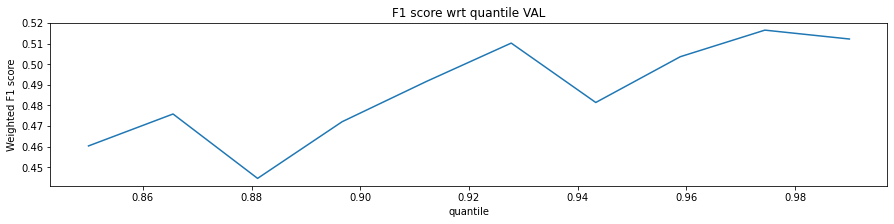

 best quantile 0.9744444444444444, F1 macro: 0.5165076834734614
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3997
           1       0.13      0.13      0.13       445

    accuracy                           0.83      4442
   macro avg       0.52      0.52      0.52      4442
weighted avg       0.83      0.83      0.83      4442



In [138]:
f1_w = []
quantile_list = np.linspace(0.85, 0.99, 10)
for q in quantile_list:
    train_vae_temp = np.where(train_res_mae > np.quantile(train_res_mae, q=q, axis=0), 1, 0).mean(axis=1)
    train_vae_temp_anomalies = np.where(train_vae_temp > (1 - q) + 0.04, 1, 0)
    f1_w.append(f1_score(train_anomalies_mae, train_vae_temp_anomalies, average='macro'))

fig = plt.figure(figsize=(15, 3))
plt.xlabel('quantile')
plt.ylabel('Weighted F1 score')
plt.title('F1 score wrt quantile VAL')
plt.plot(quantile_list, f1_w)
plt.show()

fig.savefig(os.path.join(ROOT, 'model_bike', 'VAE', 'quantile_grid_search.png'))

quantile_vae_temp = quantile_list[np.argmax(f1_w)]
print(f' best quantile {quantile_list[np.argmax(f1_w)]}, F1 macro: {np.max(f1_w)}')

train_vae_temp = np.where(train_res_mae > np.quantile(train_res_mae, q=quantile_vae_temp, axis=0), 1,
                              0).mean(axis=1)
train_vae_temp_anomalies = np.where(train_vae_temp > (1 - quantile_vae_temp) + 0.04, 1, 0)
print(classification_report(train_anomalies_mae, train_vae_temp_anomalies))

In [139]:
val_vae_temp = np.where(val_res_mae > np.quantile(train_res_mae, q=quantile_vae_temp, axis=0), 1, 0).mean(
    axis=1)
val_vae_temp_anomalies = np.where(val_vae_temp > (1 - quantile_vae_temp) + 0.04, 1, 0)
print(classification_report(val_anomalies_mae, val_vae_temp_anomalies))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1350
           1       0.08      0.08      0.08       131

    accuracy                           0.85      1481
   macro avg       0.50      0.50      0.50      1481
weighted avg       0.84      0.85      0.84      1481



In [140]:
test_vae_temp = np.where(test_res_mae > np.quantile(train_res_mae, q=quantile_vae_temp, axis=0), 1, 0).mean(
    axis=1)
test_vae_temp_anomalies = np.where(test_vae_temp > (1 - quantile_vae_temp) + 0.04, 1, 0)
print(classification_report(test_anomalies_mae, test_vae_temp_anomalies))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5347
           1       0.12      0.11      0.12       576

    accuracy                           0.83      5923
   macro avg       0.51      0.51      0.51      5923
weighted avg       0.83      0.83      0.83      5923



### PCA

100%|██████████| 18/18 [00:00<00:00, 30.46it/s]


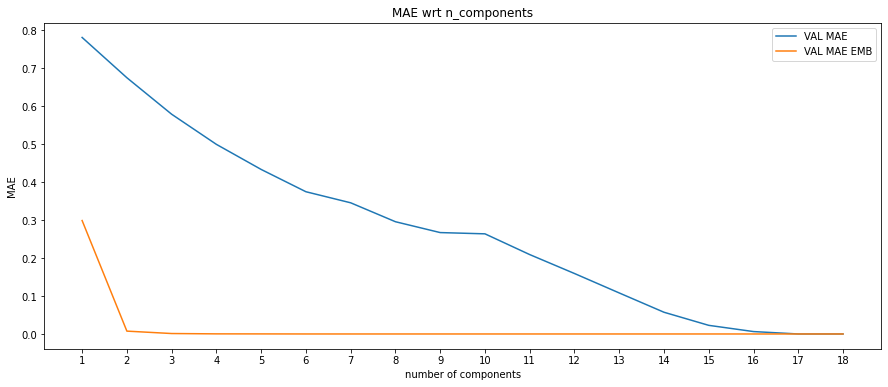

In [141]:
grid_search = True

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_val_std = scaler.transform(x_val)
x_test_std = scaler.transform(x_test)

if grid_search == True:

    mean_mae_val_list_noemb = []
    for el in tqdm(range(18)):
        pca = PCA(n_components = el)
        pca = pca.fit(x_train_std)
        mean_mae_val,_ = pca_reconstruct(x_val_std, pca)
        mean_mae_val_list_noemb.append(np.mean(mean_mae_val))

    fig = plt.figure(figsize =(15,6))
    plt.plot(np.arange(1,19),mean_mae_val_list_noemb, label = 'VAL MAE')
    plt.plot(np.arange(1,19),mean_mae_val_list[:18], label = 'VAL MAE EMB')
    plt.xticks(np.arange(1,19), np.arange(1,19,dtype= np.int32))
    plt.title('MAE wrt n_components')
    plt.xlabel('number of components')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    fig.savefig(os.path.join(CHECKPOINT_ROOT2,'PCA','mae_values.png'))

In [142]:
pca = PCA(n_components = 10)
pca = pca.fit(x_train_std)

train_rec_err, train_rec = pca_reconstruct(x_train_std, pca)
val_rec_err, val_rec = pca_reconstruct(x_val_std, pca)
test_rec_err,test_rec = pca_reconstruct(x_test_std, pca)

In [143]:
val_rec_err.mean()

0.20907951636807748

In [144]:
train_mae_pca = pd.DataFrame(np.abs(train_rec -x_train_std ))
val_mae_pca = pd.DataFrame(np.abs(val_rec - x_val_std))
test_mae_pca = pd.DataFrame(np.abs(test_rec - x_test_std ))

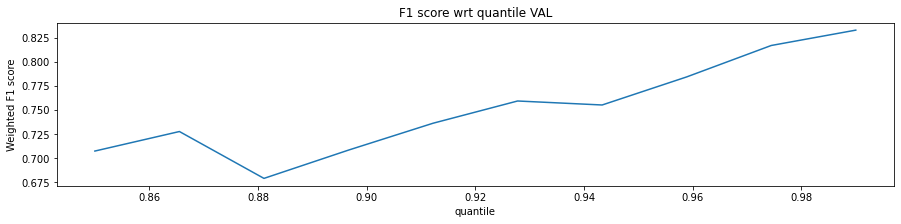

 best quantile 0.99, F1 macro: 0.8328239591036596

 classification report 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      3997
           1       0.14      0.12      0.13       445

    accuracy                           0.84      4442
   macro avg       0.52      0.52      0.52      4442
weighted avg       0.83      0.84      0.83      4442



In [145]:
from sklearn.metrics import  f1_score
f1_w = []
quantile_list = np.linspace(0.85,0.99,10)
for q in quantile_list:
    train_prob = np.where(train_mae_pca > train_mae_pca.quantile(q = q, axis = 0), 1, 0).mean(axis = 1)
    train_pred_anomalies_pca = np.where(train_prob > (1-q) + 0.04 ,1,0 )
    f1_w.append(f1_score(train_anomalies_mae, train_pred_anomalies_pca,average = 'weighted'))

fig = plt.figure(figsize = (15,3))
plt.xlabel('quantile')
plt.ylabel('Weighted F1 score')
plt.title('F1 score wrt quantile VAL')
plt.plot(quantile_list, f1_w)
plt.show()
fig.savefig(os.path.join(ROOT,'model_bike','PCA', 'quantile_gird_search2.png'))

quantile_pca_temp = quantile_list[np.argmax(f1_w)]
print(f' best quantile {quantile_list[np.argmax(f1_w)]}, F1 macro: {np.max(f1_w)}')

train_prob = np.where(train_mae_pca > train_mae_pca.quantile(q = quantile_pca_temp, axis = 0), 1, 0).mean(axis = 1)
train_pred_anomalies_pca = np.where(train_prob > (1-quantile_pca_temp) + 0.04 ,True, False )
print(f'\n classification report \n {classification_report(train_anomalies_mae, train_pred_anomalies_pca)}')

In [146]:
val_prob = np.where(val_mae_pca > train_mae_pca.quantile(q=quantile_pca_temp, axis=0), 1, 0).mean(axis=1)
val_pred_anomalies_pca = np.where(val_prob > (1 - quantile_pca_temp) + 0.04, True, False)
print(f'\n classification report \n {classification_report(val_anomalies_mae, val_pred_anomalies_pca)}')



 classification report 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1350
           1       0.09      0.10      0.10       131

    accuracy                           0.83      1481
   macro avg       0.50      0.50      0.50      1481
weighted avg       0.84      0.83      0.84      1481



In [147]:
test_prob = np.where(test_mae_pca > train_mae_pca.quantile(q=quantile_pca_temp, axis=0), 1, 0).mean(axis=1)
test_pred_anomalies_pca = np.where(test_prob > (1 - quantile_pca_temp) + 0.04, True, False)
print(f'\n classification report \n {classification_report(test_anomalies_mae, test_pred_anomalies_pca)}')


 classification report 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      5347
           1       0.13      0.11      0.12       576

    accuracy                           0.84      5923
   macro avg       0.52      0.52      0.52      5923
weighted avg       0.83      0.84      0.83      5923



### MODEL IMPLEMENTATION

In [27]:
dataset_tr = MaeDataset(pd.DataFrame(train).drop(col_mapper['count'], axis = 1).values,
                        pd.DataFrame(train)[col_mapper['count']].values)
train_dataloader = DataLoader(dataset_tr,32)

dataset_val = MaeDataset(pd.DataFrame(val).drop(col_mapper['count'], axis = 1).values,
                        pd.DataFrame(val)[col_mapper['count']].values)
val_dataloader = DataLoader(dataset_val,32)

dataset_test = MaeDataset(pd.DataFrame(test).drop(col_mapper['count'], axis = 1).values,
                        pd.DataFrame(test)[col_mapper['count']].values)
test_dataloader = DataLoader(dataset_test,32)

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
obj = partial(objective, dataset_train = dataset_tr, dataset_val = dataset_val,num_epoch = 150, in_features = 18)
study.optimize(obj, n_trials = 30)

In [29]:
# model's parameters
lr = 0.005
num_epochs = 50
log_interval = 100

# model initialization
bike_nn = MLP(18, p = 0.015)

# Optimization
optimizer = Adam(bike_nn.parameters(), lr = lr, weight_decay = 0.001)

# Learning Rate schedule
scheduler = lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.07 )

In [ ]:
bike_nn

In [30]:
# load model
LOAD_MODEL = True

if LOAD_MODEL:
    checkpoint = torch.load( os.path.join(CHECKPOINT_ROOT2, 'MLP', 'mlp_model.pt'))
    bike_nn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_epoch_mae = checkpoint['epoch']
    best_mae = checkpoint['loss']

In [ ]:
statistics = training_loop(num_epochs, optimizer, scheduler,
                           log_interval, bike_nn, train_dataloader,
                           val_dataloader)

In [ ]:
best_epoch_mae = np.argmin(statistics['val_mae_values']) + 1
best_mae= statistics['val_mae_values'][best_epoch_mae - 1]

print(f'Best mae: {best_mae:.5f} epoch: {best_epoch_mae}')

In [68]:
torch.save({
    'epoch': best_epoch_mae,
    'model_state_dict': bike_nn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': best_mae,
}, os.path.join(CHECKPOINT_ROOT2, 'MLP', 'mlp_model.pt'))

In [69]:
for k in statistics.keys():
    try:
        statistics[k] = [float(el) for el in statistics[k]]
    except:
        pass
with open(os.path.join(CHECKPOINT_ROOT2, 'MLP', 'model_stats.json'), 'w+') as f:
    json.dump(statistics, f)

In [18]:
statistics.keys()

dict_keys(['loss_values_train', 'loss_values_val', 'train_mae_values', 'val_mae_values', 'time'])

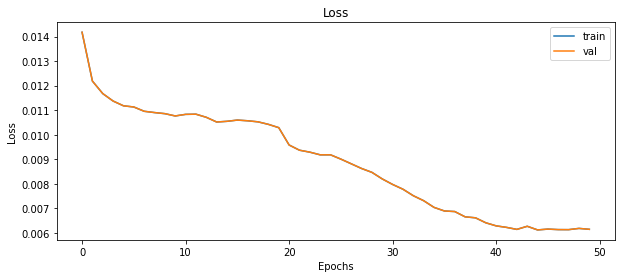

In [70]:
fig = plt.figure(figsize=(10, 4))
plt.title(f'Loss')
plt.plot(np.arange(num_epochs), statistics['loss_values_train'], label='train')
plt.plot(np.arange(num_epochs), statistics['loss_values_val'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2, 'MLP', 'loss.png'))

In [23]:
np.array([el.detach().numpy() for el in statistics['train_mae_values']]).reshape(-1)

array([0.16667505, 0.15939763, 0.15958598, 0.15960306, 0.1595979 ,
       0.15943296, 0.15933602, 0.1593636 , 0.15938452, 0.15939417,
       0.15939558, 0.15941802, 0.15940079, 0.15941632, 0.15941878,
       0.1594167 , 0.15941861, 0.1594203 , 0.15946639, 0.15940857,
       0.15958376, 0.15920384, 0.15914279, 0.15913257, 0.15913112,
       0.159131  , 0.15913117, 0.15913136, 0.15913147, 0.1591316 ,
       0.15913174, 0.15913178, 0.15913188, 0.15913193, 0.15913199,
       0.15913205, 0.15913205, 0.15913208, 0.15913211, 0.15913217,
       0.15929377, 0.15927127, 0.15925126, 0.15923347, 0.15921769,
       0.15920353, 0.15919113, 0.15918005, 0.1591705 , 0.15916196],
      dtype=float32)

In [73]:
statistics['train_mae_values']

[0.12692202627658844,
 0.1176479309797287,
 0.11468688398599625,
 0.11300887167453766,
 0.11192814260721207,
 0.11137255281209946,
 0.11086523532867432,
 0.11014051735401154,
 0.10985071212053299,
 0.10971947014331818,
 0.1099524050951004,
 0.11008016765117645,
 0.1093505248427391,
 0.10814473778009415,
 0.10816796869039536,
 0.10831693559885025,
 0.10803136974573135,
 0.10819713771343231,
 0.10728195309638977,
 0.10665479302406311,
 0.10294509679079056,
 0.10129175335168839,
 0.10103093832731247,
 0.10015883296728134,
 0.10000220686197281,
 0.0989539623260498,
 0.09789876639842987,
 0.0966327041387558,
 0.09511636197566986,
 0.09364975988864899,
 0.09231961518526077,
 0.09109512716531754,
 0.08959092199802399,
 0.08843238651752472,
 0.08651723712682724,
 0.08556419610977173,
 0.08533501625061035,
 0.0842122733592987,
 0.08410797268152237,
 0.08233096450567245,
 0.08187028765678406,
 0.08113876730203629,
 0.08069072663784027,
 0.08140997588634491,
 0.08051835745573044,
 0.0804747492074

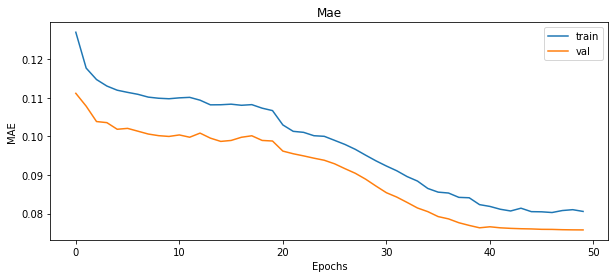

In [74]:
fig = plt.figure(figsize=(10, 4))

plt.title(f'Mae')
plt.plot(np.arange(num_epochs), statistics['train_mae_values'] , label='train')
plt.plot(np.arange(num_epochs), statistics['val_mae_values'], label='val')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2, 'MLP', 'mae.png'))

In [38]:
# Intgrated Gradient
attr = []
ig = IntegratedGradients(bike_nn)
for idx_batch, (el, y) in tqdm(enumerate(DataLoader(dataset_tr,1, shuffle = False)), desc = "Sample"):
    attr.append(ig.attribute(el).detach().numpy())


Sample:: 4782it [02:40, 29.73it/s]


In [76]:
feature_importance = dict(zip(list(train_df.drop(columns = 'count').columns),
                              list(np.array(attr).squeeze(1).mean(axis = 0))))

NameError: name 'attr' is not defined

In [65]:
tuple(feature_importance.keys())

('holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'weather_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'hour',
 'day',
 'month',
 'year')

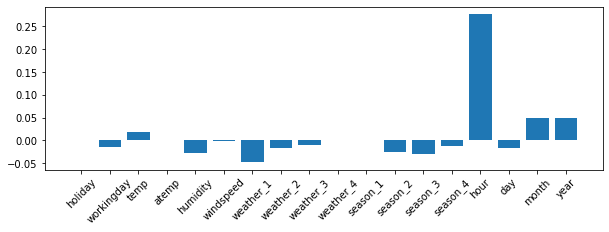

In [71]:
plt.figure(figsize=(10,3))
plt.bar(np.arange(18), list(feature_importance.values()))
plt.xticks(np.arange(18), list(feature_importance.keys()), rotation = 45)
plt.show()

In [ ]:
train_pred = compute_prediction(bike_nn, dataset_tr,is_vae = False)
val_pred = compute_prediction(bike_nn, dataset_val,is_vae = False)
test_pred = compute_prediction(bike_nn, dataset_test ,is_vae = False)

In [ ]:
train_mae = np.abs(np.array(train_pred).reshape(-1) - y_train)
mae_threshold = np.quantile(train_mae, 0.9)
print(f'MAE threshold setted at {mae_threshold}')

In [ ]:
y_train_unscaled = min_max_scaler.inverse_transform(train)[:,col_mapper['count']]

train_temp = copy.deepcopy(train)
train_temp[:, col_mapper['count']] = np.array(train_pred).reshape(-1)
y_pred_unscaled = min_max_scaler.inverse_transform(train_temp)[:,col_mapper['count']]

print(f' Average MAE unscaled: {np.abs(y_train_unscaled - y_pred_unscaled).mean()} \n')

plt.figure(figsize = (15,3))
plt.title('Real vs Pred')
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(np.arange(100),y_pred_unscaled[:100], label = 'pred')
plt.plot(np.arange(100),y_train_unscaled[:100], label = 'real')
plt.legend()

plt.show()

In [ ]:
val_mae = np.abs(np.array(val_pred).reshape(-1) - y_val)
val_anomalies_mae = (val_mae > mae_threshold)
print(f'val mae: {val_mae.mean()} \n'
      f' perc. of anomalies: {np.count_nonzero(val_anomalies_mae) / len(val_anomalies_mae)}')

In [ ]:
test_mae = np.abs(np.array(test_pred).reshape(-1) - y_test)
test_anomalies_mae = (test_mae > mae_threshold)
print(f' test mae: {test_mae.mean()} \n'
      f'perc. of anomalies: {np.count_nonzero(test_anomalies_mae) / len(test_anomalies_mae)}')

### Dropout

In [148]:
variance_train = compute_variance(bike_nn, dataset_tr, 100)
print(
    f'Avg variance {np.mean(variance_train)}\nmedian variance {np.median(variance_train)}\n99Q: {np.quantile(variance_train, 0.99)} \n')

print(f'setting threshold on {np.quantile(variance_train, 0.9)}')

error_thresh_dropout = np.quantile(variance_train, 0.9)


100%|██████████| 100/100 [17:48<00:00, 10.68s/it]
c:\users\39320\netlov\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
c:\users\39320\netlov\lib\site-packages\numpy\lib\function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
error_thresh_dropout = np.quantile(variance_train, 0.9)

In [ ]:
variance_val = compute_variance(bike_nn, dataset_val, 100)
val_anomalies_dropout = (variance_val > error_thresh_dropout)

print(
    f'Avg error {np.mean(val_anomalies_dropout)}\nmedian error {np.median(val_anomalies_dropout)}\n'
    f' perc. of anomalies: {np.count_nonzero(val_anomalies_dropout) / len(val_anomalies_dropout)}')

In [ ]:
val_anomalies_dropout = (variance_val > error_thresh_dropout)

In [ ]:
print(classification_report(np.zeros(len(val_anomalies_dropout)),val_anomalies_dropout))

In [ ]:
print(classification_report(val_anomalies_mae,val_anomalies_dropout))

In [ ]:
variance_test = compute_variance(bike_nn, dataset_test, 100)
test_anomalies_dropout = (variance_test > error_thresh_dropout)

print(
    f'Avg error {np.mean(test_anomalies_dropout)}\nmedian error {np.median(test_anomalies_dropout)}\n'
    f' perc. of anomalies: {np.count_nonzero(test_anomalies_dropout) / len(test_anomalies_dropout)}')

In [ ]:
print(classification_report(np.ones(len(test_anomalies_dropout)),test_anomalies_dropout))

In [109]:
print(classification_report(test_anomalies_mae,test_anomalies_dropout))

              precision    recall  f1-score   support

       False       0.90      0.99      0.95      5347
        True       0.34      0.03      0.06       576

    accuracy                           0.90      5923
   macro avg       0.62      0.51      0.50      5923
weighted avg       0.85      0.90      0.86      5923



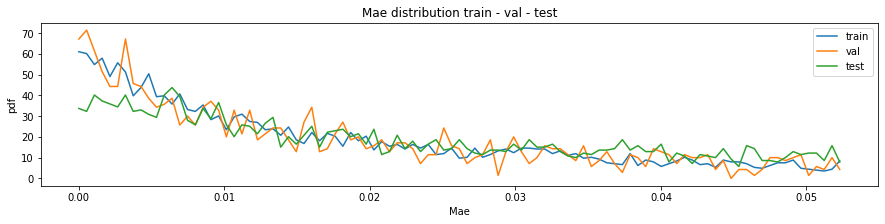

In [270]:
stop = np.quantile(np.concatenate([train_mae, val_mae, test_mae]), q = 0.75)

plt.figure(figsize = (15,3))
plt.plot(np.linspace(0, stop, 100)[:-1],density_func(train_mae, stop), label = 'train')
plt.plot(np.linspace(0, stop, 100)[:-1],density_func(val_mae, stop), label = 'val')
plt.plot(np.linspace(0, stop, 100)[:-1],density_func(test_mae, stop), label = 'test')
plt.legend()
plt.xlabel('Mae')
plt.ylabel('pdf')
plt.title('Mae distribution train - val - test')
plt.show()

# extracting embedding

In [50]:
# defining outliers based on mae values

bike_nn.embedding = False
train_pred = compute_prediction(bike_nn, dataset_tr, is_vae=False)
val_pred = compute_prediction(bike_nn, dataset_val, is_vae=False)
test_pred = compute_prediction(bike_nn, dataset_test, is_vae = False)

train_mae = np.abs(np.array(train_pred).reshape(-1) - y_train)
val_mae = np.abs(np.array(val_pred).reshape(-1) - y_val)
test_mae = np.abs(np.array(test_pred).reshape(-1) - y_test)

In [108]:
train_anomalies_mae = np.where(train_mae > np.quantile(train_mae, q = 0.9),1,0)
val_anomalies_mae = np.where(val_mae > np.quantile(train_mae, q = 0.9),1,0)
test_anomalies_mae = np.where(test_mae > np.quantile(train_mae, q = 0.9),1,0)

In [52]:
# extracting embedding
bike_nn.embedding = True

train_embedding = compute_prediction(bike_nn, dataset_tr,is_vae = False)
val_embedding = compute_prediction(bike_nn, dataset_val,is_vae = False)
test_embedding = compute_prediction(bike_nn, dataset_test ,is_vae = False)

train_embedding = pd.DataFrame(np.array(train_embedding).squeeze(1), columns = ['dim_'+str(el) for el in range(64)])
val_embedding = pd.DataFrame(np.array(val_embedding).squeeze(1), columns = ['dim_'+str(el) for el in range(64)])
test_embedding = pd.DataFrame(np.array(test_embedding).squeeze(1), columns = ['dim_'+str(el) for el in range(64)])

100%|██████████| 64/64 [00:03<00:00, 19.36it/s]


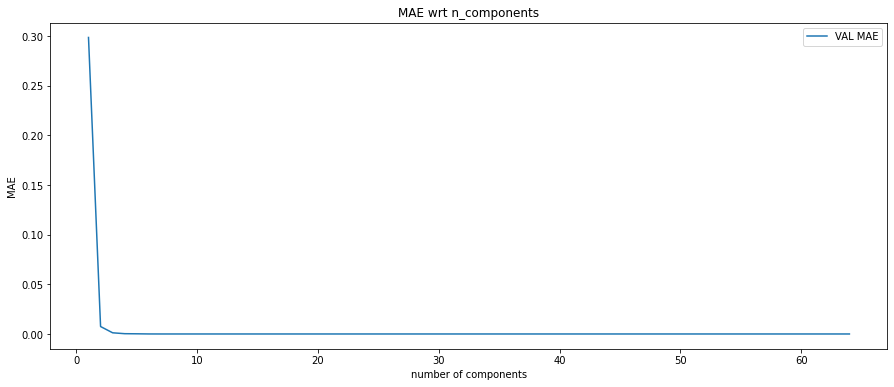

In [32]:
#1) PCA on embedding

grid_search = True

scaler = StandardScaler()
train_embedding_std = scaler.fit_transform(train_embedding)
val_embedding_std = scaler.transform(val_embedding)
test_embedding_std = scaler.transform(test_embedding)

if grid_search == True:

    mean_mae_val_list = []
    for el in tqdm(range(64)):
        pca = PCA(n_components = el)
        pca = pca.fit(train_embedding_std)
        mean_mae_val,_ = pca_reconstruct(train_embedding_std, pca)
        mean_mae_val_list.append(np.mean(mean_mae_val))

    fig = plt.figure(figsize =(15,6))
    plt.plot(np.arange(1,65),mean_mae_val_list, label = 'VAL MAE')
    plt.title('MAE wrt n_components')
    plt.xlabel('number of components')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    #fig.savefig(os.path.join(CHECKPOINT_ROOT2,'PCA','mae_values.png'))

In [33]:
pca = PCA(n_components = 5)
pca = pca.fit(train_embedding_std)

train_embedding_err, train_embedding_rec = pca_reconstruct(train_embedding_std, pca)
val_embedding_err, val_embedding_rec = pca_reconstruct(val_embedding_std, pca)
test_embedding_err, test_embedding_rec = pca_reconstruct(test_embedding_std, pca)

train_mae_pca = pd.DataFrame(np.abs(train_embedding_rec -train_embedding_std ))
val_mae_pca = pd.DataFrame(np.abs(val_embedding_rec - val_embedding_std))
test_mae_pca = pd.DataFrame(np.abs(test_embedding_rec - test_embedding_std ))

In [196]:
val_rec_err.mean()

0.20907951636807748

In [195]:
val_embedding_err.mean()

2.7744405e-05

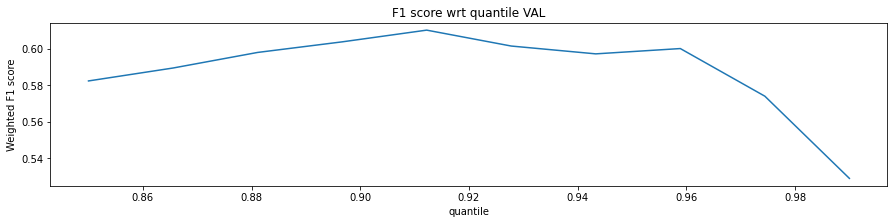

 best quantile 0.9122222222222222, F1 macro: 0.6100958270949167

 classification report 
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      3997
           1       0.31      0.28      0.29       445

    accuracy                           0.87      4442
   macro avg       0.62      0.61      0.61      4442
weighted avg       0.86      0.87      0.86      4442



In [193]:
from sklearn.metrics import  f1_score
f1_w = []
quantile_list = np.linspace(0.85,0.99,10)
for q in quantile_list:
    train_prob = np.where(train_mae_pca > train_mae_pca.quantile(q = q, axis = 0), 1, 0).mean(axis = 1)
    train_pred_anomalies_pca = np.where(train_prob > (1-q) + 0.04 ,1,0 )
    f1_w.append(f1_score(train_anomalies_mae, train_pred_anomalies_pca,average = 'macro'))

fig = plt.figure(figsize = (15,3))
plt.xlabel('quantile')
plt.ylabel('Weighted F1 score')
plt.title('F1 score wrt quantile VAL')
plt.plot(quantile_list, f1_w)
plt.show()
fig.savefig(os.path.join(ROOT,'model_bike','PCA', 'quantile_gird_search2.png'))

quantile_pca_temp = quantile_list[np.argmax(f1_w)]
print(f' best quantile {quantile_list[np.argmax(f1_w)]}, F1 macro: {np.max(f1_w)}')

train_prob = np.where(train_mae_pca > train_mae_pca.quantile(q = quantile_pca_temp, axis = 0), 1, 0).mean(axis = 1)
train_pred_anomalies_pca = np.where(train_prob > (1-quantile_pca_temp) + 0.04 ,True, False )
print(f'\n classification report \n {classification_report(train_anomalies_mae, train_pred_anomalies_pca)}')

In [139]:
val_prob = np.where(val_mae_pca > train_mae_pca.quantile(q = quantile_pca_temp, axis = 0), 1, 0).mean(axis = 1)
val_pred_anomalies_pca = np.where(val_prob > (1-quantile_pca_temp) + 0.04 ,True, False )
print(f'\n classification report \n {classification_report(val_anomalies_mae, val_pred_anomalies_pca)}')


 classification report 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1350
           1       0.28      0.27      0.28       131

    accuracy                           0.88      1481
   macro avg       0.61      0.60      0.60      1481
weighted avg       0.87      0.88      0.87      1481



In [140]:
test_prob = np.where(test_mae_pca > train_mae_pca.quantile(q = quantile_pca_temp, axis = 0), 1, 0).mean(axis = 1)
test_pred_anomalies_pca = np.where(test_prob > (1-quantile_pca_temp) + 0.04 ,True, False )
print(f'\n classification report \n {classification_report(test_anomalies_mae, test_pred_anomalies_pca)}')


 classification report 
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      5347
           1       0.30      0.28      0.29       576

    accuracy                           0.87      5923
   macro avg       0.61      0.60      0.61      5923
weighted avg       0.86      0.87      0.87      5923



In [34]:
# 2) VAE
min_max_scaler = MinMaxScaler()
train_embedding_min_max = min_max_scaler.fit_transform(train_embedding)
val_embedding_min_max = min_max_scaler.transform(val_embedding)
test_embedding_min_max = min_max_scaler.transform(test_embedding)

batch_size = 32
dataset_train_vae_emb = VaeDataset(train_embedding_min_max)
train_dataloader_vae_emb = DataLoader(dataset_train_vae_emb, batch_size)

dataset_val_vae_emb = VaeDataset(val_embedding_min_max)
val_dataloader_vae_emb = DataLoader(dataset_val_vae_emb, batch_size)

dataset_test_vae_emb = VaeDataset(test_embedding_min_max)
test_dataloader_vae_emb = DataLoader(dataset_test_vae_emb, batch_size)


In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
obj = partial(objective_vae, dataset_train=dataset_train_vae_emb, dataset_val=dataset_val_vae_emb, num_epoch=50,
              in_features=64)
study.optimize(obj, n_trials=30)

In [71]:
LOAD = True
if LOAD == True:
    best_param_emb = json_load(os.path.join(ROOT, 'model_bike', 'VAE', 'best_params_emb.json'))
else:
    best_trial_emb = study.best_trial
    best_param_emb = best_trial_emb.params

    for key, value in best_param_emb.items():
        print("{}: {}".format(key, value))

learning_rate: 0.0009545502762648369
criterion: BCELoss
reduction: sum
optimizer: Adam
strategy: False
hidden_dim: 40
hidden_channels: 1
latent_dim: 3
betascheduler_start: 0.08741541385307657
betascheduler_stop: 0.3412011212221119
betascheduler_ratio: 0.7952026770162751


In [72]:
with open(os.path.join(ROOT, 'model_bike', 'VAE', 'best_params_emb.json'), 'w') as f:
    json.dump(best_param_emb, f)

In [73]:
# model's parameters
vae_lr_emb = best_param_emb['learning_rate']  #0.0002
vae_num_epochs_emb = 250
strategy1_emb = best_param_emb['strategy']
start_emb = best_param_emb['betascheduler_start']
stop_emb = best_param_emb['betascheduler_stop']
ratio_emb = best_param_emb['betascheduler_ratio']

# model initialization

betascheduler_train_emb = Betascheduler(vae_num_epochs_emb, len(train_dataloader_vae_emb) + 1, start=start_emb, stop=stop_emb, ratio=ratio_emb)
betascheduler_val_emb= Betascheduler(vae_num_epochs_emb, len(val_dataloader_vae_emb) + 1, start=start_emb, stop=stop_emb, ratio=ratio_emb)

# Optimization
criterion_emb = getattr(torch.nn, best_param_emb['criterion'])(reduction=best_param_emb['reduction'])
# nn.MSELoss(reduction = 'sum')

# model initialization
bike_vae_emb = build_model_vae(best_param_emb, 64)
vae_optimizer_emb = getattr(torch.optim, best_param_emb['optimizer'])(bike_vae_emb.parameters(), lr=vae_lr)

# Learning Rate schedule
vae_scheduler_emb = lr_scheduler.StepLR(vae_optimizer_emb, step_size=vae_num_epochs_emb, gamma=1)

--------------------------------------------------------
Betascheduler:
current beta = 0.08741541385307657
current iteration = 0
current epoch = 0
--------------------------------------------------------


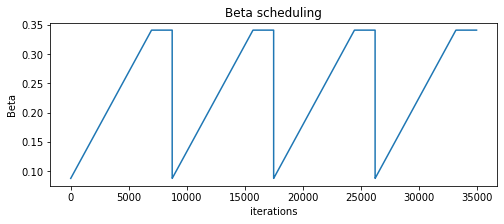

In [74]:
betascheduler_val_emb.summary()

plt.figure(figsize=(8, 3))
plt.plot(np.arange(betascheduler_train_emb.n_iter), betascheduler_train_emb.schedule[:-1])
plt.title('Beta scheduling')
plt.xlabel('iterations')
plt.ylabel('Beta')
plt.show()

In [75]:
# load model

if LOAD:
    checkpoint = torch.load(os.path.join(ROOT, 'model_bike', 'VAE', 'vae_model_emb.pt'))
    bike_vae_emb.load_state_dict(checkpoint['model_state_dict'])
    vae_optimizer_emb.load_state_dict(checkpoint['optimizer_state_dict'])
    vae_scheduler_emb.load_state_dict(checkpoint['scheduler_state_dict'])
    vae_epoch_emb = checkpoint['epoch']
    vae_loss_emb = checkpoint['loss']



In [76]:
vae_statistics_emb = vae_training_loop(vae_num_epochs_emb,
                                       vae_optimizer_emb,
                                       vae_scheduler_emb,
                                       bike_vae_emb,
                                       train_dataloader_vae_emb,
                                       val_dataloader_vae_emb,
                                       betascheduler_train_emb,
                                       betascheduler_val_emb,
                                       strategy1 = strategy1_emb, #False
                                       criterion=criterion_emb)



Epoch: 1  Lr: 0.00071620  Loss: Train = [11039.7321] - Val = [15607.4291]  KLD: Train = [176.5267] - Val = [560.6680]  REC: Train = [790.9711] - Val = [481.5386]  Time one epoch (s): 1.6360 
Epoch: 2  Lr: 0.00071620  Loss: Train = [46114.3802] - Val = [17303.4181]  KLD: Train = [712.2535] - Val = [597.6552]  REC: Train = [390.5054] - Val = [424.2121]  Time one epoch (s): 1.6219 
Epoch: 3  Lr: 0.00071620  Loss: Train = [129556.6189] - Val = [355739.1866]  KLD: Train = [545.0780] - Val = [529.3233]  REC: Train = [364.9825] - Val = [343.3044]  Time one epoch (s): 1.3589 
Epoch: 4  Lr: 0.00071620  Loss: Train = [2238785.8680] - Val = [1957206.8317]  KLD: Train = [695.8111] - Val = [782.2960]  REC: Train = [342.7679] - Val = [336.0112]  Time one epoch (s): 1.9900 
Epoch: 5  Lr: 0.00071620  Loss: Train = [6647549.1117] - Val = [8027563.6956]  KLD: Train = [810.2549] - Val = [830.1050]  REC: Train = [340.7348] - Val = [334.2982]  Time one epoch (s): 1.9552 
Epoch: 6  Lr: 0.00071620  Loss: Tra

In [77]:
best_epoch_loss_vae = np.argmin(vae_statistics_emb['loss_mae_val']) + 1
best_loss_vae = vae_statistics_emb['loss_mae_val'][best_epoch_loss_vae - 1]

print(f'Best val mae: {best_loss_vae: .5f} epoch: {best_epoch_loss_vae}')
# Save the model

Best val mae:  0.00018 epoch: 247


In [78]:
EPOCH = best_epoch_loss_vae
CHECKPOINT_ROOT2 = os.path.join(ROOT, 'model_bike')
LOSS = best_loss_vae

if not os.path.exists(CHECKPOINT_ROOT2):
    os.makedirs(CHECKPOINT_ROOT2)

torch.save({
    'epoch': EPOCH,
    'model_state_dict': bike_vae_emb.state_dict(),
    'optimizer_state_dict': vae_optimizer.state_dict(),
    'scheduler_state_dict': vae_scheduler.state_dict(),
    'loss': LOSS,
}, os.path.join(CHECKPOINT_ROOT2, 'VAE', 'vae_model_emb.pt'))

In [79]:
vae_statistics_emb['loss_mae_val'] = list(np.array(vae_statistics_emb['loss_mae_val']).reshape(-1))
vae_statistics_emb['loss_mae_train'] = list(np.array(vae_statistics_emb['loss_mae_train']).reshape(-1))
for k in vae_statistics_emb.keys():
    try:
        vae_statistics_emb[k] = [float(el) for el in vae_statistics_emb[k]]
    except:
        pass
with open(os.path.join(CHECKPOINT_ROOT2, 'VAE', 'model_stats_emb.json'), 'w+') as f:
    json.dump(vae_statistics_emb, f)

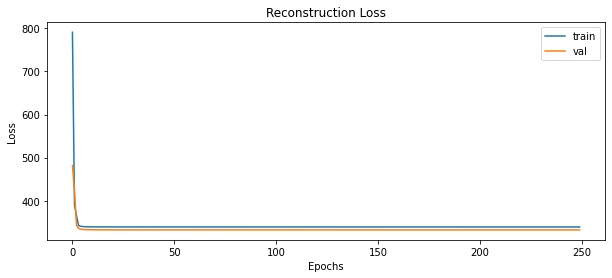

In [80]:
fig = plt.figure(figsize=(10, 4))
plt.title(f'Reconstruction Loss')
plt.plot(np.arange(vae_num_epochs_emb), vae_statistics_emb['loss_rec_train'], label='train')
plt.plot(np.arange(vae_num_epochs_emb), vae_statistics_emb['loss_rec_val'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2, 'VAE', 'rec_loss_emb.png'))


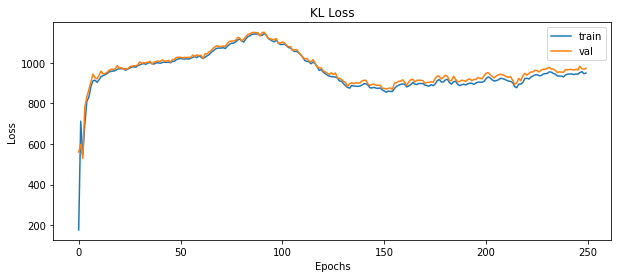

In [82]:
fig = plt.figure(figsize=(10, 4))
plt.title(f'KL Loss')
plt.plot(np.arange(vae_num_epochs_emb), np.array(vae_statistics_emb['loss_kld_train']), label='train')
plt.plot(np.arange(vae_num_epochs_emb), np.array(vae_statistics_emb['loss_kld_val']), label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2, 'VAE', 'kl_loss_emb.png'))

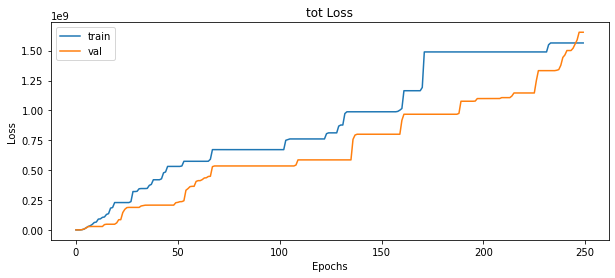

In [83]:
fig = plt.figure(figsize=(10, 4))

plt.title(f'tot Loss')
plt.plot(np.arange(vae_num_epochs_emb), np.array(vae_statistics_emb['loss_values_train']), label='train')
plt.plot(np.arange(vae_num_epochs_emb), np.array(vae_statistics_emb['loss_values_val']), label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2, 'VAE', 'tot_loss_emb.png'))

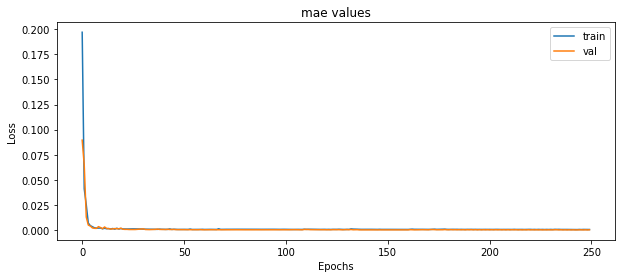

In [84]:
fig = plt.figure(figsize=(10, 4))

plt.title(f'mae values')

plt.plot(np.arange(vae_num_epochs_emb), np.array(vae_statistics_emb['loss_mae_train']), label='train')
plt.plot(np.arange(vae_num_epochs_emb), np.array(vae_statistics_emb['loss_mae_val']), label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT2, 'VAE', 'mae_loss_emb.png'))

### VAE USUAL

In [85]:
train_res_emb, _ = compute_prediction(bike_vae_emb,dataset_train_vae_emb, has_real = False)
train_res_emb = np.array([el.numpy() for el in train_res_emb]).squeeze(1)
train_res_emb_mae = np.abs(train_res_emb - train_embedding_min_max)

val_res_emb, _ = compute_prediction(bike_vae_emb,dataset_val_vae_emb, has_real = False)
val_res_emb = np.array([el.numpy() for el in val_res_emb]).squeeze(1)
val_res_emb_mae = np.abs(val_res_emb - val_embedding_min_max)

test_res_emb, _ = compute_prediction(bike_vae_emb,dataset_test_vae_emb, has_real = False)
test_res_emb = np.array([el.numpy() for el in test_res_emb]).squeeze(1)
test_res_emb_mae = np.abs(test_res_emb - test_embedding_min_max)

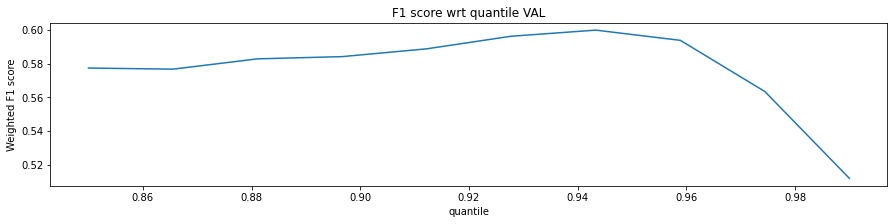

 best quantile 0.9433333333333334, F1 macro: 0.59985361596712
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3997
           1       0.26      0.32      0.29       445

    accuracy                           0.84      4442
   macro avg       0.59      0.61      0.60      4442
weighted avg       0.86      0.84      0.85      4442



In [87]:
f1_w = []
quantile_list = np.linspace(0.85,0.99,10)
for q in quantile_list:
    train_vae_temp_emb = np.where(train_res_emb_mae > np.quantile(train_res_emb_mae, q = q, axis = 0), 1, 0).mean(axis = 1)
    train_vae_temp_anomalies_emb = np.where(train_vae_temp_emb > (1-q) + 0.04 ,1,0 )
    f1_w.append(f1_score(train_anomalies_mae, train_vae_temp_anomalies_emb, average = 'macro'))

fig = plt.figure(figsize = (15,3))
plt.xlabel('quantile')
plt.ylabel('Weighted F1 score')
plt.title('F1 score wrt quantile VAL')
plt.plot(quantile_list, f1_w)
plt.show()

fig.savefig(os.path.join(ROOT,'model_bike','VAE','quantile_grid_search_emb.png'))

quantile_vae_temp = quantile_list[np.argmax(f1_w)]
print(f' best quantile {quantile_list[np.argmax(f1_w)]}, F1 macro: {np.max(f1_w)}')

train_vae_temp_emb = np.where(train_res_emb_mae > np.quantile(train_res_emb_mae, q = quantile_vae_temp, axis = 0), 1, 0).mean(axis = 1)
train_vae_temp_anomalies_emb = np.where(train_vae_temp_emb > (1-quantile_vae_temp) + 0.04 ,1,0 )
print(classification_report(train_anomalies_mae, train_vae_temp_anomalies_emb))

In [88]:
val_vae_temp_emb = np.where(val_res_emb_mae > np.quantile(train_res_emb_mae, q = quantile_vae_temp, axis = 0), 1, 0).mean(axis = 1)
val_vae_temp_anomalies_emb = np.where(val_vae_temp_emb > (1-quantile_vae_temp) + 0.04 ,1,0 )
print(classification_report(val_anomalies_mae, val_vae_temp_anomalies_emb))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1350
           1       0.24      0.31      0.27       131

    accuracy                           0.85      1481
   macro avg       0.58      0.61      0.59      1481
weighted avg       0.87      0.85      0.86      1481



In [89]:
test_vae_temp_emb = np.where(test_res_emb_mae > np.quantile(train_res_emb_mae, q = quantile_vae_temp, axis = 0), 1, 0).mean(axis = 1)
test_vae_temp_anomalies_emb = np.where(test_vae_temp_emb > (1-quantile_vae_temp) + 0.04 ,1,0 )
print(classification_report(test_anomalies_mae, test_vae_temp_anomalies_emb))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5347
           1       0.26      0.32      0.28       576

    accuracy                           0.84      5923
   macro avg       0.59      0.61      0.60      5923
weighted avg       0.86      0.84      0.85      5923



### VAE MEAN


In [151]:
res = np.empty((100, len(dataset_train_vae_emb), 64))
bike_vae_emb.eval()
bike_vae_emb.training = True

with torch.no_grad():
    for idx_batch, el in tqdm(enumerate(DataLoader(dataset_train_vae_emb, 1, shuffle=False))):
        for b in range(100):
            pred, _ = bike_vae_emb(el)
            res[b, idx_batch, :] = pred
train_mean_vae_emb = res.mean(axis=0)
train_mean_vae_emb.shape

4442it [05:09, 14.37it/s]


(4442, 64)

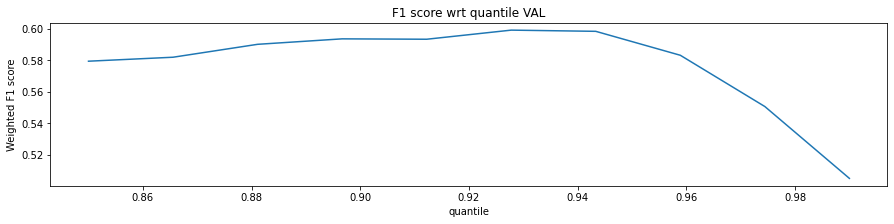

 best quantile 0.9277777777777778, F1 macro: 0.5991004417258782

 classification report 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      3997
           1       0.16      0.05      0.08       445

    accuracy                           0.88      4442
   macro avg       0.53      0.51      0.50      4442
weighted avg       0.83      0.88      0.85      4442



In [152]:
f1_w = []
quantile_list = np.linspace(0.85, 0.99, 10)
for q in quantile_list:
    train_prob = np.where(train_mean_vae_emb > np.quantile(train_mean_vae_emb, q=q, axis=0), 1, 0).mean(axis=1)
    train_pred_anomalies_vae_mean_emb = np.where(train_prob > (1 - q) + 0.04, 1, 0)
    f1_w.append(f1_score(train_anomalies_mae, train_pred_anomalies_vae_mean_emb, average='macro'))

fig = plt.figure(figsize=(15, 3))
plt.xlabel('quantile')
plt.ylabel('Weighted F1 score')
plt.title('F1 score wrt quantile VAL')
plt.plot(quantile_list, f1_w)
plt.show()
fig.savefig(os.path.join(ROOT, 'model_bike', 'PCA', 'quantile_gird_search2_emb.png'))

quantile_vae_mean_temp_emb = quantile_list[np.argmax(f1_w)]
print(f' best quantile {quantile_list[np.argmax(f1_w)]}, F1 macro: {np.max(f1_w)}')

train_prob = np.where(train_mean_vae > np.quantile(train_mean_vae, q=quantile_vae_mean_temp_emb, axis=0), 1, 0).mean(axis=1)
train_pred_anomalies_vae_mean = np.where(train_prob > (1 - quantile_vae_mean_temp_emb) + 0.04, True, False)
print(f'\n classification report \n {classification_report(train_anomalies_mae, train_pred_anomalies_vae_mean_emb)}')

In [153]:
res = np.empty((100, len(dataset_val_vae_emb), 64))
bike_vae_emb.eval()
bike_vae_emb.training = True

with torch.no_grad():
    for idx_batch, el in tqdm(enumerate(DataLoader(dataset_val_vae_emb, 1, shuffle=False))):
        for b in range(100):
            pred, _ = bike_vae_emb(el)
            res[b, idx_batch, :] = pred

1481it [01:43, 14.32it/s]


In [154]:
val_mean_vae_emb = res.mean(axis=0)
val_prob = np.where(val_mean_vae_emb > np.quantile(train_mean_vae_emb, q=quantile_vae_mean_temp_emb, axis=0), 1, 0).mean(axis=1)
val_pred_anomalies_vae_mean_emb = np.where(val_prob > (1 - quantile_vae_mean_temp_emb) + 0.04, True, False)
print(f'\n classification report \n {classification_report(val_anomalies_mae, val_pred_anomalies_vae_mean_emb)}')


 classification report 
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      1350
           1       0.24      0.38      0.30       131

    accuracy                           0.84      1481
   macro avg       0.59      0.63      0.60      1481
weighted avg       0.87      0.84      0.86      1481



In [155]:
res = np.empty((100, len(dataset_test_vae_emb), 64))
bike_vae_emb.eval()
bike_vae_emb.training = True

with torch.no_grad():
    for idx_batch, el in tqdm(enumerate(DataLoader(dataset_test_vae_emb, 1, shuffle=False))):
        for b in range(100):
            pred, _ = bike_vae_emb(el)
            res[b, idx_batch, :] = pred

test_mean_vae_emb = res.mean(axis=0)
test_prob = np.where(test_mean_vae_emb > np.quantile(train_mean_vae_emb, q=quantile_vae_mean_temp_emb, axis=0), 1, 0).mean(axis=1)
test_pred_anomalies_vae_mean_emb = np.where(test_prob > (1 - quantile_vae_mean_temp_emb) + 0.04, True, False)
print(f'\n classification report \n {classification_report(test_anomalies_mae, test_pred_anomalies_vae_mean_emb)}')

5923it [06:27, 15.30it/s]



 classification report 
               precision    recall  f1-score   support

           0       0.93      0.88      0.90      5347
           1       0.25      0.38      0.30       576

    accuracy                           0.83      5923
   macro avg       0.59      0.63      0.60      5923
weighted avg       0.86      0.83      0.84      5923



### 3) DROPOUT

In [156]:

bike_nn.embedding = False

train_drop, variance_train = compute_variance(bike_nn, dataset_tr, 100)
mean_train = train_drop.mean(axis = 0)
val_drop, variance_val = compute_variance(bike_nn, dataset_val, 100)
mean_val = val_drop.mean(axis = 0)
test_drop, variance_test = compute_variance(bike_nn, dataset_test, 100)
mean_test = test_drop.mean(axis = 0)

100%|██████████| 100/100 [12:36<00:00,  7.57s/it]


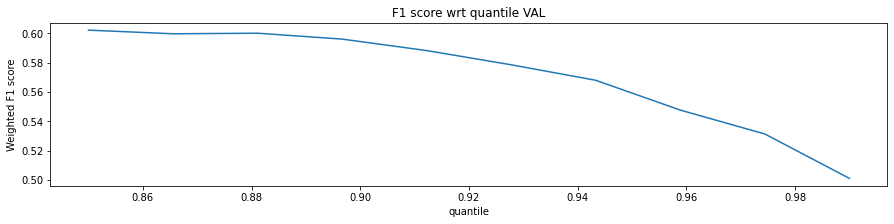

 best quantile 0.85, F1 macro: 0.602184284481833
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      3997
           1       0.25      0.38      0.30       445

    accuracy                           0.83      4442
   macro avg       0.59      0.63      0.60      4442
weighted avg       0.86      0.83      0.84      4442



In [158]:
f1_w = []
quantile_list = np.linspace(0.85,0.99,10)
for q in quantile_list:
    train_var_temp = np.where(variance_train > np.quantile(variance_train, q = q), 1, 0)
    train_var_temp_anomalies = np.where(train_var_temp > (1-q) + 0.04 ,1,0 )
    f1_w.append(f1_score(train_anomalies_mae, train_var_temp_anomalies,average = 'macro'))

fig = plt.figure(figsize = (15,3))
plt.xlabel('quantile')
plt.ylabel('Weighted F1 score')
plt.title('F1 score wrt quantile VAL')
plt.plot(quantile_list, f1_w)
plt.show()
fig.savefig(os.path.join(ROOT,'model_bike','DROPOUT','quantile_grid_search.png'))

quantile_var_temp = quantile_list[np.argmax(f1_w)]
print(f' best quantile {quantile_list[np.argmax(f1_w)]}, F1 macro: {np.max(f1_w)}')

train_var_temp = np.where(variance_train > np.quantile(variance_train, q  = quantile_var_temp), 1, 0)
train_var_temp_anomalies = np.where(train_var_temp > (1-quantile_var_temp) + 0.04 ,1,0 )
print(classification_report(train_anomalies_mae, train_var_temp_anomalies))


In [159]:
val_var_temp = np.where(variance_val > np.quantile(variance_train, quantile_var_temp), 1, 0)
val_var_temp_anomalies = np.where(val_var_temp > (1-quantile_var_temp) + 0.04 ,1,0 )
print(classification_report(val_anomalies_mae, val_var_temp_anomalies))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1350
           1       0.23      0.37      0.29       131

    accuracy                           0.83      1481
   macro avg       0.58      0.63      0.60      1481
weighted avg       0.87      0.83      0.85      1481



In [160]:
test_var_temp = np.where(variance_test > np.quantile(variance_train, quantile_var_temp), 1, 0)
test_var_temp_anomalies = np.where(test_var_temp > (1-quantile_var_temp) + 0.04 ,1,0 )
print(classification_report(test_anomalies_mae, test_var_temp_anomalies))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      5347
           1       0.25      0.38      0.30       576

    accuracy                           0.83      5923
   macro avg       0.59      0.63      0.60      5923
weighted avg       0.86      0.83      0.84      5923



In [ ]:
# mean

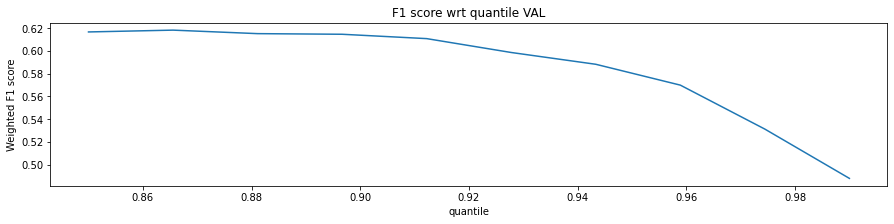

 best quantile 0.8655555555555555, F1 macro: 0.6181629052881435
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3997
           1       0.28      0.38      0.33       445

    accuracy                           0.84      4442
   macro avg       0.61      0.64      0.62      4442
weighted avg       0.86      0.84      0.85      4442



In [161]:
f1_w = []
quantile_list = np.linspace(0.85,0.99,10)
for q in quantile_list:
    train_mean_temp = np.where(mean_train > np.quantile(mean_train, q = q), 1, 0)
    train_mean_temp_anomalies = np.where(train_mean_temp > (1-q) + 0.04 ,1,0 )
    f1_w.append(f1_score(train_anomalies_mae, train_mean_temp_anomalies,average = 'macro'))

fig = plt.figure(figsize = (15,3))
plt.xlabel('quantile')
plt.ylabel('Weighted F1 score')
plt.title('F1 score wrt quantile VAL')
plt.plot(quantile_list, f1_w)
plt.show()
fig.savefig(os.path.join(ROOT,'model_bike','DROPOUT','quantile_grid_search_mean.png'))

quantile_mean_temp = quantile_list[np.argmax(f1_w)]
print(f' best quantile {quantile_list[np.argmax(f1_w)]}, F1 macro: {np.max(f1_w)}')

train_mean_temp = np.where(mean_train > np.quantile(mean_train, q  = quantile_mean_temp), 1, 0)
train_mean_temp_anomalies = np.where(train_mean_temp > (1-quantile_mean_temp) + 0.04 ,1,0 )
print(classification_report(train_anomalies_mae, train_mean_temp_anomalies))


In [162]:
val_mean_temp = np.where(mean_val > np.quantile(mean_train, quantile_mean_temp), 1, 0)
val_mean_temp_anomalies = np.where(val_mean_temp > (1 - quantile_mean_temp) + 0.04, 1, 0)
print(classification_report(val_anomalies_mae, val_mean_temp_anomalies))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1350
           1       0.25      0.40      0.31       131

    accuracy                           0.84      1481
   macro avg       0.60      0.64      0.61      1481
weighted avg       0.88      0.84      0.86      1481



In [163]:
test_mean_temp = np.where(mean_test > np.quantile(mean_train, quantile_mean_temp), 1, 0)
test_mean_temp_anomalies = np.where(test_mean_temp > (1 - quantile_mean_temp) + 0.04, 1, 0)
print(classification_report(test_anomalies_mae, test_mean_temp_anomalies))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      5347
           1       0.27      0.38      0.32       576

    accuracy                           0.84      5923
   macro avg       0.60      0.63      0.61      5923
weighted avg       0.87      0.84      0.85      5923



In [166]:
bike_nn

MLP(
  (first): Linear(in_features=18, out_features=1024, bias=True)
  (last): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.015, inplace=False)
  (additional_hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
)

aggregated 1d- hypothesis test with Bonferroni/FDR Correction

In [66]:
df_train = pd.DataFrame(train, columns=col_list)
df_val = pd.DataFrame(val, columns=col_list)
df_test = pd.DataFrame(test, columns=col_list)

 KS Val anomalies: [] 

Psi Val anomalies: []


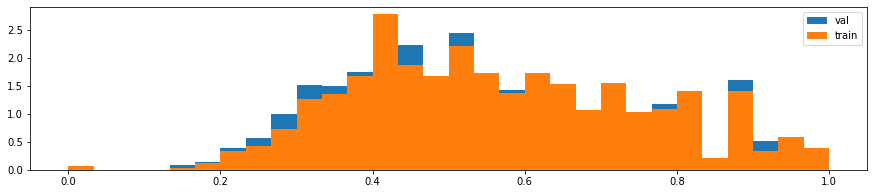

In [67]:
# 1d Test - VAL
ks_values_val = df_val.drop(columns = 'count').apply(lambda x: compute_1d_test(x,df_train.drop(columns = 'count'), test = 'ks'))
psi_values_val = df_val.drop(columns = 'count').apply(lambda x: compute_1d_test(x,df_train.drop(columns = 'count'), test = 'psi'))

print(f''' KS Val anomalies: {np.array(df_val.drop(columns = 'count').columns)[np.where(ks_values_val< 0.05,True, False)]} \n
Psi Val anomalies: {np.array(df_val.drop(columns = 'count').columns)[np.where(psi_values_val > 0.2,True, False)]}''')

plt.figure(figsize = (15,3))
plt.hist(df_val['humidity'], label = 'val', bins = 30, density = True)
plt.hist(df_train['humidity'], label = 'train',bins = 30, density = True)
plt.legend()
plt.show()

 KS Val anomalies: [] 

Psi Val anomalies: []


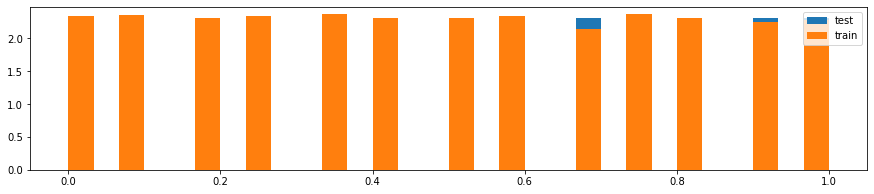

In [68]:
# 1d test - TEST
ks_values_test = df_test.drop(columns = 'count').apply(lambda x: compute_1d_test(x,df_train.drop(columns = 'count'), test = 'ks'))
psi_values_test = df_test.drop(columns = 'count').apply(lambda x: compute_1d_test(x,df_train.drop(columns = 'count'), test = 'psi'))

print(f''' KS Val anomalies: {np.array(df_test.drop(columns = 'count').columns)[np.where(ks_values_test< 0.05,True, False)]} \n
Psi Val anomalies: {np.array(df_test.drop(columns = 'count').columns)[np.where(psi_values_test > 0.2,True, False)]}''')

plt.figure(figsize = (15,3))
plt.hist(df_test['hour'], label = 'test', bins = 30, density = True)
plt.hist(df_train['hour'], label = 'train',bins = 30, density = True)
plt.legend()
plt.show()

In [69]:
# Aggregated 1D test - VAL
perc_val, res_val = compute_aggregated_1d(df_train.drop(columns = 'count'), df_val.drop(columns = 'count'), test = 'ks')
print(f' The {round(perc_val*100,3)}% of dimension is drifted')

 The 0.0% of dimension is drifted


In [177]:
perc_test, res_test = compute_aggregated_1d(df_train.drop(columns = 'count'), df_test.drop(columns = 'count'), test = 'ks')
print(f' The {round(perc_test*100,3)}% of dimension is drifted')

 The 0.0% of dimension is drifted


1d Aggregated

In [56]:
def compute_1d_test(reference_col: Union[pd.Series, np.ndarray],
                    current_df : Union[pd.DataFrame, np.ndarray],
                    test:str = 'ks'):
    '''
    :param reference_col: column in reference dataset
    :param current_col: DataFrame in current day/period
    :param test: ks - psi - chisq
    :return: pvalue/statistics of the test
    '''
    current_col = current_df[reference_col.name]
    start = min(min(current_col),min(reference_col))
    stop = max(max(current_col),max(reference_col))
    bins = np.linspace(start, stop, 100)

    ref_freq, _ = np.histogram(reference_col, bins = bins, density = True)
    curr_freq, _ = np.histogram(current_col, bins = bins, density = True)

    if test == 'ks':
        res = scipy.stats.ks_2samp(ref_freq, curr_freq).pvalue

    elif test == 'psi':
        # PSI < 0.1 no change - PSI >=0.1 moderate PDI > 0.2 - high
        res = psi.calculate_psi(ref_freq, ref_freq)
    elif test == 'chisq':
        res = scipy.stats.chisquare(ref_freq, curr_freq).pvalue
    else:
        print('Specify a valis test: ks - psi - chisq')

    return res

In [57]:
ks_val = pd.DataFrame(x_val).apply(lambda y :compute_1d_test(y,pd.DataFrame(x_train),'ks'))
ks_perc_val = np.where(ks_val < 0.05, True,False).mean(axis = 0)
if ks_perc_val > 0:
    print(f'''percetunale di dimensioni drifttate:{round(ks_perc_val,4)*100}% ''')
    print('different dimension:')
    for el in ks_val.index[[np.where(ks_val < 0.05, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

 Nessuna dimensione driftata


In [58]:
ks_val = pd.DataFrame(val_embedding).apply(lambda y :compute_1d_test(y,pd.DataFrame(train_embedding),'ks'))
ks_perc_val = np.where(ks_val < 0.05, True,False).mean(axis = 0)
if ks_perc_val > 0:
    print(f'''percetunale di dimensioni drifttate:{round(ks_perc_val,4)*100}% ''')
    print('different dimension:')
    for el in ks_val.index[[np.where(ks_val < 0.05, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


 Nessuna dimensione driftata


In [59]:
psi_val = pd.DataFrame(x_val).apply(lambda y :compute_1d_test(y,pd.DataFrame(x_train),'psi'))
psi_perc_val = np.where(psi_val > 0.2, True,False).mean(axis = 0)
if psi_perc_val > 0:
    print(f'''percetunale di dimensioni drifttate:{round(psi_perc_val,4)*100}% ''')
    print('different dimension:')
    for el in psi_val.index[[np.where(psi_val > 0.2, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

 Nessuna dimensione driftata


In [60]:
psi_val = pd.DataFrame(val_embedding).apply(lambda y :compute_1d_test(y,pd.DataFrame(train_embedding),'psi'))
psi_perc_val = np.where(psi_val > 0.2, True,False).mean(axis = 0)
if psi_perc_val > 0:
    print(f'''percetunale di dimensioni drifttate:{round(psi_perc_val,4)*100}% ''')
    print('different dimension:')
    for el in psi_val.index[[np.where(psi_val > 0.2, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


 Nessuna dimensione driftata


In [61]:
ks_test = pd.DataFrame(x_test).apply(lambda y :compute_1d_test(y,pd.DataFrame(x_train),'ks'))
ks_perc_test = np.where(ks_test < 0.05, True,False).mean(axis = 0)
if ks_perc_test > 0:
    print(f'''percetunale di dimensioni drifttate:{ks_perc_test} ''')
    print('different dimension:')
    for el in ks_val.index[[np.where(ks_test < 0.05, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

 Nessuna dimensione driftata


In [62]:
ks_test = pd.DataFrame(test_embedding).apply(lambda y :compute_1d_test(y,pd.DataFrame(train_embedding),'ks'))
ks_perc_test = np.where(ks_test < 0.05, True,False).mean(axis = 0)
if ks_perc_test > 0:
    print(f'''percetunale di dimensioni drifttate:{ks_perc_test} ''')
    print('different dimension:')
    for el in ks_val.index[[np.where(ks_test < 0.05, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


 Nessuna dimensione driftata


In [63]:
psi_test = pd.DataFrame(x_test).apply(lambda y :compute_1d_test(y,pd.DataFrame(x_train),'psi'))
psi_perc_test = np.where(psi_test > 0.2, True,False).mean(axis = 0)
if psi_perc_test > 0:
    print(f'''percetunale di dimensioni drifttate:{psi_perc_test} ''')
    print('different dimension:')
    for el in psi_test.index[[np.where(psi_test > 0.2, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

 Nessuna dimensione driftata


In [64]:
psi_test = pd.DataFrame(test_embedding).apply(lambda y :compute_1d_test(y,pd.DataFrame(train_embedding),'psi'))
psi_perc_test = np.where(psi_test > 0.2, True,False).mean(axis = 0)
if psi_perc_test > 0:
    print(f'''percetunale di dimensioni drifttate:{psi_perc_test} ''')
    print('different dimension:')
    for el in psi_test.index[[np.where(psi_test > 0.2, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


 Nessuna dimensione driftata
